In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import pearsonr

from brian2 import *
from brian2tools import *

style.use('seaborn-v0_8-colorblind')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
logging.getLogger('brian2').setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.WARNING)

/home/patricia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# 1. Neuron and synapse model

### 1.1 Neuron model

In this tutorial we will use a **Leaky-Integrate and Fire (LIF)** neuron. The mathematical definition of the LIF is the following:

\begin{align*}
C_m \frac{dv}{dt} = g_l \cdot (E_L - v)+ I_{\eta} \end{align*}

where:
- $C_m$ is the capacitance of the membrane
- $g_l$ the leak conductance
- $I_{\eta} $ is a noisy current representing background activity

We implement this model using [BRIAN](https://brian2.readthedocs.io/en/stable/). The slider in the following plot allows you to increase and decrease the variance $I_\sigma$ of the noisy background current. A red dot indicates that the neuron spikes.


In [2]:
# Set neuron parameters
E_l = -79 * mV
v_spike = -49 * mV
C_m = 180 * pF
g_l = 18 * nS

I_mu = 0 * pA
# These parameters yield a membrane time constant of 10 ms
# Constant input needs to be ~540 pA to induce regular spiking

# Neuron equations
LIF_eq_simple = '''
dv/dt = (g_l * (E_l - v) + I_eta) / C_m : volt (unless refractory)
dI_eta/dt = (I_mu - I_eta) / tau_noise + I_sigma * xi * tau_noise**-0.5 : ampere
I_sigma : ampere
tau_noise : second
'''

# Define the neurons. Syntax: NeuronGroup(number of neurons, differential equation)
# You can also define further properties like method, threshold, reset, refactory period etc.

def run_brian_neurons(strength):

    start_scope()  # Clean Brian2 workspace
    
    LIF_neuron = NeuronGroup(
        1, LIF_eq_simple,
        threshold='v > v_spike',
        reset='v = E_l',
        refractory=3 * ms,
        method='euler' 
    )
    
    LIF_neuron.I_sigma = strength * pA
    LIF_neuron.tau_noise = C_m / g_l
    LIF_neuron.v = E_l  # Initialise the membrane potential to its starting value

    # To store activity, we need to define monitors
    spikemon = SpikeMonitor(LIF_neuron)
    statemon = StateMonitor(LIF_neuron, ['v', 'I_eta'], record=True, dt=1 * ms)

    run(3000 * ms, report=None)

    return spikemon, statemon


def update_brianplot(noise_sig):
    spikemon, statemon = run_brian_neurons(noise_sig)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    
    ax[0].plot(statemon.t / ms, statemon.I_eta[0] / pA)
    ax[0].set_ylabel(r'Input current [pA]')
    ax[0].grid(True)

    ax[1].plot(statemon.t / ms, statemon.v[0] / mV)
    ax[1].scatter(spikemon.t / ms, np.full_like(spikemon.t, v_spike / mV + 1), color='r', s=10, label='Spikes') # We plot indicators for the spike a bit above the spike threshold. If you want to plot a spike raster you can use SpikeMonitor
    ax[1].set_xlabel('Time [ms]')
    ax[1].set_ylabel('Membrane voltage [mV]')
    ax[1].grid(True)

    ax[0].set_title('LIF Neuron')
    fig.tight_layout()
    plt.show()

# Create a slider
slider = widgets.FloatSlider(value=250, min=100, max=1000, step=50, description="I_σ [pA]:", continuous_update=False)

# Link slider to update function
interactive_plot = widgets.interactive_output(update_brianplot, {'noise_sig': slider})

# Display slider and interactive plot
display(slider, interactive_plot)


FloatSlider(value=250.0, continuous_update=False, description='I_σ [pA]:', max=1000.0, min=100.0, step=50.0)

Output()

### 1.2 Synapse model

**Conductance-based synapses** model the synaptic current as a function of the momentary membrane potential. The conductance $g$ increases whenever a presynaptic spike occurs and then decays exponentially back to baseline. The synaptic current $ I^{syn} $ received by a postsynaptic neuron is given by:

\begin{align*} \frac{dg}{dt} &= - \frac{g}{\tau_{syn}} + s \\ I^{syn}(t) &=  w \cdot g(t)\cdot (v(t) - E_{e,i})
 \end{align*}

where:
- $s=1$ when a presynaptic spike occurs and $s=0$ otherwise
- $w$ is the synaptic weight between the presynaptic and postsynaptic neuron
- $E_{e, i}$ is the synaptic reversal potential.

When many synapses converge onto a postsynaptic neuron, the total synaptic current is the sum over all individual currents, each weighted by their respective synaptic strength. Luckily, BRIAN handles this automatically.

In BRIAN, synapses are defined similarly to Neuron groups. The typical syntax is ```Synapse(Pre_Neuron_Group, Post_Neuron_Group, on_pre, on_post ...)```. 

The ```on_pre``` and ```on_post``` arguments are event-triggered operations. This means that whenever a spike is detected in the presynaptic population, the operation defined by ```on_pre``` is carried out.

In the following example, we use a regularly spiking neuron from a ```SpikeGeneratorGroup``` as the presynaptic source.

In [3]:
# Synaptic reversal potentials
E_e = 0 * mV
E_i = -80 * mV

# Postsynaptic neuron model with excitatory input
LIF_eq_inp = '''
dv/dt = (g_l * (E_l - v) - g_e * (v - E_e)) / C_m : volt (unless refractory)
dg_e/dt = -g_e / tau_syn : siemens
tau_syn : second
'''

# Synapse model: static weight
syn_eq = '''w : siemens'''  # Our synapse only transmit activity, it is not plastic - so we only need one parameter w
on_pre_eq = '''g_e += w'''  # Whenever a presynaptic spike occurs, the conductance is increased by w. Here, we only look at an excitatory synapse; change all _e to _i to look at the effect of an inhibitory synapse

In [4]:
def run_connected_neurons(syn_strength):
    start_scope()  # Clean Brian2 workspace

    # Presynaptic neuron spikes every 10 ms
    N_pre = SpikeGeneratorGroup(1, np.zeros(10, dtype=int), np.arange(0, 100, 10) * ms)
    
    # Postsynaptic neuron with conductance-based input
    N_post = NeuronGroup(
        1, LIF_eq_inp,
        threshold='v > v_spike',
        reset='v = E_l',
        refractory=3 * ms,
        method='euler'
    )
    N_post.v = E_l
    N_post.tau_syn = 10 * ms

    # Synapse setup
    curr_syn = Synapses(N_pre, N_post, syn_eq, on_pre=on_pre_eq)
    curr_syn.connect('i == j')
    curr_syn.w = syn_strength * nS

    # Monitors
    pre_s = SpikeMonitor(N_pre)
    post_s = SpikeMonitor(N_post)
    record_v = StateMonitor(N_post, 'v', record=True, dt=1 * ms)

    run(120 * ms, report=None)

    return pre_s, post_s, record_v

In [5]:
def update_conductanceplot(w):
    spike_pre, spike_post, v = run_connected_neurons(w)

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(v.t / ms, v.v[0] / mV, color='b')
    ax.scatter(spike_pre.t / ms, np.full_like(spike_pre.t, v_spike / mV + 1), color='r', s=20, label='Pre')
    ax.scatter(spike_post.t / ms, np.full_like(spike_post.t, v_spike / mV + 2), color='b', s=20, label='Post')
    
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Membrane voltage [mV]')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', frameon=False)
    fig.tight_layout()
    plt.show()

# Create a slider for synaptic weight
slider = widgets.FloatSlider(value=10, min=0, max=20, step=1, description="w:", continuous_update=False)

# Use interactive to update the plot when the slider moves
interactive_plot = widgets.interactive_output(update_conductanceplot, {'w': slider})

# Display slider and interactive plot
display(slider, interactive_plot)

FloatSlider(value=10.0, continuous_update=False, description='w:', max=20.0, step=1.0)

Output()

# 2. Activity regimes in networks of spiking neurons

So far, we have only considered single neurons. In this section, we define an excitatory and an inhibitory neural population which are randomly connected with a connection probability of 10%. This results in four types of synaptic connections: E→E, E→I, I→E, and I→I.

### 2.1 Coefficient of variation 

A common way to measure the temporal structure of neural activity is the **Coefficient of Variation (CV)** of the inter-spike intervals (ISI):

\begin{align*}CV = \frac{\sigma}{\mu} \end{align*}

For neural data, this is calculated based on the ISIs of spike trains. A value of $CV = 1$ indicates irregular or Poisson-like spiking. If $CV > 1$, the neuron shows more irregularity than a Poisson process, whereas a $CV < 1$ indicates more regular firing. A regularly spiking neuron such as an LIF neuron driven by constant input typically has $CV = 0$. 

The cell below defines a function that takes spike times and computes the CV of the inter-spike intervals.

In [6]:
def CV_calc(spike_mon):
    # Compute inter-spike intervals (ISIs)
    trains = spike_mon.spike_trains()
    all_isis = [np.diff(trains[i] / ms) for i in trains if len(trains[i]) > 1]
    
    if not all_isis:
        return np.nan  # No ISIs to compute

    ISIs = np.concatenate(all_isis)
    mean = np.nanmean(ISIs)
    sd = np.nanstd(ISIs)
    
    return sd / mean if mean > 0 else np.nan

### 2.2 Spike correlelogram 

Another way to characterise the activity of spiking neural networks is by assessing the **degree of synchronicity** across neurons. Are multiple neurons active at the same time?

To quantify synchronicity, we compute the **spike correlogram**. This is defined as the distribution of all pairwise correlation coefficients between spike trains:

\begin{align*}CC(i,j) = \rho(s^i, s^j)  = \frac{\sum_t (s^i_t - \mu(s^i))(s^j_t - \mu(s^j))}{\sqrt{\sum_t(s^i_t - \mu(s^i))^2}\sqrt{\sum_t(s^j_t - \mu(s^j))^2}}\end{align*}

Where:
- $s^i$ is the full spike train of neuron i 
- $s^i_t = 1$ if neuron $i$ spikes at timepoint $t$, and 0 otherwise

In practice, this is implemented using ```numpy.corrcoef```, which computes the full cross-correlation matrix between spike trains.

Note: we only take into account active neurons. The correlation of a constant array (e.g., all zeros for silent neurons or all ones for persistently active neurons) is undefined.

In [7]:
def CC_calc(spike_mon, sim_time, N, dt=1):
    trains = spike_mon.spike_trains()
    num_bins = int(sim_time / dt)
    raster = np.zeros((N, num_bins))

    for i in range(N):
        if i in trains:
            spike_bins = (trains[i] / ms / dt).astype(int)
            spike_bins = spike_bins[spike_bins < num_bins]  # avoid out-of-bounds
            raster[i, spike_bins] = 1.0

    # Exclude neurons with constant spike trains (all 0s or all 1s)
    spike_sums = np.sum(raster, axis=1)
    include = np.where((spike_sums > 0) & (spike_sums < num_bins))[0]

    if len(include) < 2:
        return np.array([])  # Not enough data for pairwise correlation

    CCs = np.corrcoef(raster[include])
    return CCs[np.triu_indices_from(CCs, k=1)]  # return upper triangle (excluding diagonal)


### 2.3 Network regimes: sychrony and irregularity

A network can be synchronous yet exhibit **irregular** spiking activity. On the other hand, neurons may spike **highly regularly**, but at different **phases**, resulting in **asynchronous** activity. Based on these distinctions, we can classify network activity into four canonical regimes:

- **Synchronous Regular (SR)**
- **Asynchronous Regular (AR)**
- **Synchronous Irregular (SI)**
- **Asynchronous Irregular (AI)**

The **SR and SI** regimes are computationally unfavorable. In these states, all neurons respond similarly to any given stimulus, meaning the information content is similar to that of a single regular spiking neuron. Such homogeneity is often viewed as **pathological**, since the network fails to differentiate between inputs.

The **AR regime** offers better representational capacity. Here, information can be distributed across distinct firing phases or frequencies among neurons or subgroups. But it still does not take advantage of the full expressive potential of a spiking network.

The **AI regime** is regarded as the most computationally powerful. Here, neurons fire irregularly and independently, allowing complex, stimulus-specific patterns of activity across the network. This regime supports rich dynamics and heterogeneous responses, making it ideal for neural coding and network-level computation.

These distinctions and their theoretical basis are thoroughly explored in:

> **Brunel, N.** (2000). *Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons*. Journal of Computational Neuroscience, 8, 183–208.


# 3. The more the merrier: the importance of network size

Activity in spiking neural networks is often driven by coincident presynaptic activity. A presynaptic spike only has a brief time window in which it can significantly depolarise the postsynaptic membrane. So multiple presynaptic spikes must occur together in order to elicit a postsynaptic spike.

Whether this excitation arises from one highly active presynaptic neuron or from the synchronous firing of several less active neurons does not matter greatly to the postsynaptic neuron - it's the timing and convergence that matter. However, the larger the network, the greater the probability that neurons will be spontaneously coactivate and drive postsynaptic activity.

To investigate this effect, we will use a standard **excitatory–inhibitory (EI) network** with a connection probability of 20%. Spontaneous activity is induced using background noise, as in the earlier LIF model. Each neuron has a spontaneous firing rate of approximately 0.6 Hz.

You can manipulate the number of excitatory neurons $N_E$ and inhibitory neurons $N_I$ using the input fields in the interactive simulation below. Synaptic weights are automatically scaled to compensate for changes in total population size, maintaining consistent postsynaptic input statistics.

![title](network.png)

In [8]:
# Network parameters
tau_noise = C_m / g_l
I_sigma = 600 * pA  # ~0.6 Hz background activity per neuron
I_mu = 0 * pA

tau_syn_e = 5 * ms
tau_syn_i = 10 * ms
w_syn = 7 * nS

N_E = 4000
N_I = 1000
p_conn = 0.2  # Connection probability

LIF_eq = '''
dv/dt = (g_l * (E_l - v) - g_e * (v - E_e) - g_i * (v - E_i) + I_eta) / C_m : volt (unless refractory)
dI_eta/dt = (I_mu - I_eta) / tau_noise + I_sigma * xi * tau_noise**-0.5 : ampere
dg_e/dt = -g_e / tau_syn_e : siemens
dg_i/dt = -g_i / tau_syn_i : siemens
'''

on_pre_E = 'g_e += w'  # Automatically understood to be postsynaptic
on_pre_I = 'g_i += w'

def run_connected_network(N_e, N_i, fac_ee, fac_ei, fac_ie, fac_ii):
    seed(5)
    start_scope()
    
    # We have one big population which we subdivide into one excitatory and one inhibitory
    N_total = N_e + N_i
    N_Pop = NeuronGroup(N_total, LIF_eq,
                        threshold='v > v_spike',
                        reset='v = E_l',
                        refractory=3 * ms,
                        method='euler')
    
    # Initial conditions around rest ±15 mV
    N_Pop.v = (np.random.rand(N_total) * 15 - 79) * mV + E_l
    
    # Connectivity
    EE = Synapses(N_Pop[:N_e], N_Pop[:N_e], syn_eq, on_pre=on_pre_E)
    EI = Synapses(N_Pop[:N_e], N_Pop[N_e:], syn_eq, on_pre=on_pre_E)
    IE = Synapses(N_Pop[N_e:], N_Pop[:N_e], syn_eq, on_pre=on_pre_I)
    II = Synapses(N_Pop[N_e:], N_Pop[N_e:], syn_eq, on_pre=on_pre_I)

    for syn, fac, N in zip([EE, EI, IE, II],
                           [fac_ee, fac_ei, fac_ie, fac_ii],
                           [N_e, N_e, N_i, N_i]):
        syn.connect(p=p_conn)
        syn.w = w_syn / np.log(N) * fac

    # Monitors
    spike_mon = SpikeMonitor(N_Pop)
    s_E = SpikeMonitor(N_Pop[:N_e])
    s_I = SpikeMonitor(N_Pop[N_e:])
    r_E = PopulationRateMonitor(N_Pop[:N_e])
    r_I = PopulationRateMonitor(N_Pop[N_e:])

    run(10 * second, report=None)

    return spike_mon, s_E, s_I, r_E, r_I

In [9]:
def update_networkplot(n_E, n_I, fac_EE, fac_EI, fac_IE, fac_II, title):
    with output:
        output.clear_output(wait=True)

        fig, ax = plt.subplots(1, 3, figsize=(18, 4))

        spike_tot, spikes_E, spikes_I, rate_e, rate_i = run_connected_network(
            n_E, n_I, fac_EE, fac_EI, fac_IE, fac_II
        )

        # Raster
        ax[0].scatter(spikes_E.t, spikes_E.i, color='r', marker='|', label='E')
        ax[0].scatter(spikes_I.t, spikes_I.i + n_E, color='b', marker='|', label='I')
        ax[0].set_xlim(9, 10)
        ax[0].set_xlabel('t [s]')
        ax[0].set_ylabel('Neuron index')

        # Rates
        ax[1].plot(rate_e.t / second, rate_e.smooth_rate(window='flat', width=1 * second) / Hz, color='r', label='E')
        ax[1].plot(rate_i.t / second, rate_i.smooth_rate(window='flat', width=1 * second) / Hz, color='b', label='I')
        ax[1].set_xlabel('t [s]')
        ax[1].set_ylabel('Firing rate [Hz]')
        ax[1].legend(loc='upper right', frameon=False)
        ax[1].grid(True)

        # Correlation histogram
        CC_vals = CC_calc(spike_tot, 10000, n_E + n_I)
        ax[2].hist(CC_vals, bins=100)
        ax[2].set_xlim(-1.05, 1.05)
        ax[2].set_xlabel('CC(i, j)')
        ax[2].set_ylabel('Count')

        # Title
        CV_val = CV_calc(spike_tot)
        fig.suptitle(f'{title}       CV: {CV_val:.2f}')
        fig.tight_layout()
        plt.show()

# Widgets
run_button = widgets.Button(description="Run simulation")

ne_input = widgets.IntText(value=400, description='N_E:', step=1)
ni_input = widgets.IntText(value=100, description='N_I:', step=1)

def on_button_click(b):
    update_networkplot(
        ne_input.value, ni_input.value,
        fac_EE=1, fac_EI=1, fac_IE=4, fac_II=4,
        title=f'$N_E$={ne_input.value}, $N_I$={ni_input.value}'
    )

output = widgets.Output()
run_button.on_click(on_button_click)

# Display UI
display(widgets.VBox([ne_input, ni_input, run_button, output]))

You should observe that:

- The **more neurons** in the network, the greater the **overall activity** due to increased synaptic interactions
- The **more excitatory neurons**, the higher the degree of synchonicity

In the following, we explore how the **relative strength of excitatory and inhibitory synapses** influence the network dynamics.

# 4. EI balance and network synchronisation

**Excitatory–inhibitory (EI) balance** is a foundational principle in neural network dynamics, and it can apply across multiple scales:

- **Broad or global EI balance** typically refers to firing rates. It means that rates co-vary over time - e.g., an increase in excitation is accompanied by a compensatory increase in inhibition.

- **Tight EI balance** refers to this co-variation on short timescales (on the order of milliseconds). Most often it refers to the instantaneous firing rates or precise spike timing of excitatory and inhibitory neurons.

- **Local EI balance** usually refers to synaptic balance at the level of individual neurons. A neuron is considered locally balanced if it receives comparable levels of excitatory and inhibitory input over time.

**Synchronisation** is closely linked to **local EI balance**. Imbalances increase the risk of excessive synchrony and pathological dynamics.

In the simulation below, you can directly manipulate local EI balance to see how it shapes network activity. The parameters $g_{EE}, g_{EI}, g_{IE}$ and $g_{II}$ control the multiplicative strength of each synapse type.

In [10]:
# Sliders for synaptic strength modifiers
ee_input = widgets.FloatText(
    value=1,
    description='g_EE:',
    step=0.01
)

ei_input = widgets.FloatText(
    value=1,
    description='g_EI:',
    step=0.01
)

ie_input = widgets.FloatText(
    value=4,
    description='g_IE:',
    step=0.01
)

ii_input = widgets.FloatText(
    value=4,
    description='g_II:',
    step=0.01
)

# Update function for custom weights
def on_button_click(b):
    title = (f'g_{{EE}}$ = {ee_input.value}; '
             f'$g_{{EI}}$ = {ei_input.value}; '
             f'$g_{{IE}}$ = {ie_input.value}; '
             f'$g_{{II}}$ = {ii_input.value}')
    
    update_networkplot(
        N_E, N_I,
        ee_input.value,
        ei_input.value,
        ie_input.value,
        ii_input.value,
        title
    )

run_button.on_click(on_button_click)

# Display UI
display(widgets.VBox([
    ee_input, ei_input, ie_input, ii_input,
    run_button, output
]))


You should observe that:
- when the **I→E** synapse is weak, the network synchronises
- when the **I→E** synapse is strong, the network desynchronises

# 5. Inhibitory plasticity can desynchronise recurrent networks and stabilise memories

In this section, we will investigate some insights and results found in:

> **Vogels, T. P., Sprekeler, H., Zenke, F., Clopath, C., & Gerstner, W.** (2011). *Inhibitory plasticity balances excitation and inhibition in sensory pathways and memory networks.* Science, 334(6062), 1569–1573.

The **objectives** of this section is to demonstrate that inhibitory plasticity 
- can desynchronise network activity
- stabilise network activity after excitatory memory insertion
- stabilise memory recall

### 5.1 Inhibitory plasticity rule 

In this work, the authors investigated an inhibitory synaptic plasticity rule which follows a **symmetric, LTP-dominated spike-timing-dependent plasticity** (STDP) kernel. Specifically:

- **Pre–post spike pairs** which occur in close succession lead to **long-term potentiation (LTP)** of the inhibitory synapse.
- Each **presynaptic spike** also induces **long-term depression (LTD)**, which acts as a counterbalance.


\begin{align}
\Delta w = \eta \cdot pre \cdot post - \alpha \cdot pre
\end{align}


We will first implement a synapse undergoing this plasticity rule to visualize the shape of the STDP kernel. You can explore how the kernel changes by adjusting:
- the time constant $\tau_{STDP}$
- and the presynaptic depression factor $\alpha$

In [11]:
# Equations and updates for the STDP inhibitory plasticity rule
syn_eq = '''
    w : 1
    dapre/dt = -apre / tau_stdp : 1 (event-driven)
    dapost/dt = -apost / tau_stdp : 1 (event-driven)
'''

onpre = '''
    apre += 1
    w = clip(w + (apost - alpha) * eta, 0, wmax)
'''

onpost = '''
    apost += 1
    w = clip(w + apre * eta, 0, wmax)
'''

# Parameters
N = 200
eta = 0.1
wmax = 2
tmax = 100 * ms

def run_sim(tau, alpha_v):
    with output:
        output.clear_output(wait=True)
        start_scope()
        seed(42)  # ensure deterministic STDP kernel

        tau_stdp = tau * ms
        alpha = alpha_v

        G = NeuronGroup(N, 'tspike : second', threshold='t > tspike', refractory=200*ms)
        H = NeuronGroup(N, 'tspike : second', threshold='t > tspike', refractory=200*ms)

        G.tspike = 'i * tmax / (N - 1)'
        H.tspike = '(N - 1 - i) * tmax / (N - 1)'

        S = Synapses(G, H, syn_eq, on_pre=onpre, on_post=onpost)
        S.connect(j='i')
        S.w = 1

        run(tmax + 1 * ms)

        fig, ax = plt.subplots(figsize=(3, 3))
        ax.plot((H.tspike - G.tspike) / ms, S.w - 1)
        ax.axhline(0, ls=':', c='grey')
        ax.axvline(0, ls=':', c='grey')
        ax.set_xlabel(r'$\Delta t$ (ms)')
        ax.set_ylabel(r'$\Delta w$')
        plt.tight_layout()
        plt.show()

# Input widgets
tau_input = widgets.IntText(
    value=20,
    description='τ (STDP):',
    step=1
)

alpha_input = widgets.FloatText(
    value=0.2,
    description='α (LTD):',
    step=0.01
)

# Run button
run_button = widgets.Button(description="Calculate STDP kernel")

# Link button to function
run_button.on_click(lambda b: run_sim(tau_input.value, alpha_input.value))

# Display
display(widgets.VBox([tau_input, alpha_input, run_button, output]))


### 5.2 Desynchronising Recurrent Activity

We learned that weak inhibition drives the network into an **un­favour­able synchronous regime**. Here we demonstrate that **plastic I→E synapses** which follow this symmetric, LTP-dominated inhibitory STDP rule can *self-tune* the network into the desirable **asynchronous irregular (AI)** state.

We'll simulate the network in two phases:
- No plasticity for 1 second to observe the default (pathological) dynamics.
- Plasticity for 9 seconds to observe how the network transitions into the AI regime.

Only the I→E synapses are plastic. We monitor both spike trains and firing rates, and track the evolution of 10 representative I→E synaptic weights. The activity is monitored for *four* neurongroups: 
- Inhibitory neurons
- Engram 1 (neurons 1800 - 2000) 
- Engram 2 (neurons 1975 - 2175)
- Baseline excitatory (neurons 0 - 200)

![title](plastic_network.png)

In [12]:
# Network configuration
N_E = 4000
N_I = 1000
C_m = 180 * pF
g_l = 18 * nS
E_l = -79 * mV
E_e = 0 * mV
E_i = -80 * mV
v_spike = -49 * mV

tau_noise = C_m / g_l
I_sigma = 400 * pA
I_mu = 0 * pA

tau_syn_e = 5 * ms
tau_syn_i = 10 * ms
tau_stdp = 20 * ms
eta = 0.01
alpha = 3 * Hz * tau_stdp * 2  # homeostatic factor to balance potentiation and depression: target rate x integration window x scaling factor
wmax = 100
p_conn = 0.02

#indexes of the engrams
engram_1 = np.arange(1800,2000,1,dtype = int)
engram_2 = np.arange(1975,2175, dtype = int)

# Neuron and synapse models

LIF_eq = '''
dv/dt = (g_l * (E_l - v) - g_e * (v - E_e) - g_i * (v - E_i) + I_eta + I_e) / C_m : volt (unless refractory)
dI_eta/dt = (I_mu - I_eta) / tau_noise + I_sigma * xi * tau_noise**-0.5 : ampere
dg_e/dt = -g_e / tau_syn_e : siemens
dg_i/dt = -g_i / tau_syn_i : siemens
I_e : ampere
'''

syn_eq_plastic = '''
w : 1
dapre/dt = -apre / tau_stdp : 1 (event-driven)
dapost/dt = -apost / tau_stdp : 1 (event-driven)
'''

syn_eq_nonplastic = 'w : 1'

on_pre_IE = '''
g_i += w * nS
apre += 1
w = clip(w + (apost - alpha) * eta, 0, wmax)
'''

on_post_IE = '''
apost += 1
w = clip(w + apre * eta, 0, wmax)
'''

on_pre_E = 'g_e += w * 3 * nS'
on_pre_I = 'g_i += w * 30 * nS'


# Construct the network
start_scope()
seed(5)

N_total = N_E + N_I
N_Pop = NeuronGroup(N_total, LIF_eq, threshold='v > v_spike', reset='v = E_l',
                    refractory=3 * ms, method='euler')
N_Pop.v = (np.random.rand(N_total) * 15 - 79) * mV

# Define the synapses
EE = Synapses(N_Pop[:N_E], N_Pop, syn_eq_nonplastic, on_pre=on_pre_E)
EE.connect(p=p_conn)
EE.w = 1

IE = Synapses(N_Pop[N_E:], N_Pop[:N_E], syn_eq_plastic, on_pre=on_pre_IE, on_post=on_post_IE)
IE.connect(p=p_conn)
IE.w = 0.0001  # Start with very weak inhibition

II = Synapses(N_Pop[N_E:], N_Pop[N_E:], syn_eq_nonplastic, on_pre=on_pre_I)
II.connect(p=p_conn)
II.w = 1



In [13]:
# Monitoring
# excitatory engram 1
s_E1 = SpikeMonitor(N_Pop[engram_1])
r_E1 = PopulationRateMonitor(N_Pop[engram_1])
# excitatory engram 2
s_E2 = SpikeMonitor(N_Pop[engram_2])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
# excitatory control group
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
# inhibitory neurons
s_I = SpikeMonitor(N_Pop[N_E:])
r_I = PopulationRateMonitor(N_Pop[N_E:])

#synapses
ws   = StateMonitor(IE, 'w', record=np.arange(10), dt=1*ms)

# Simulation: Phase 1 (No plasticity)
eta = 0
run(1 * second, report=None)

# Simulation: Phase 2 (Plasticity)
eta = 0.01
run(9 * second, report=None)

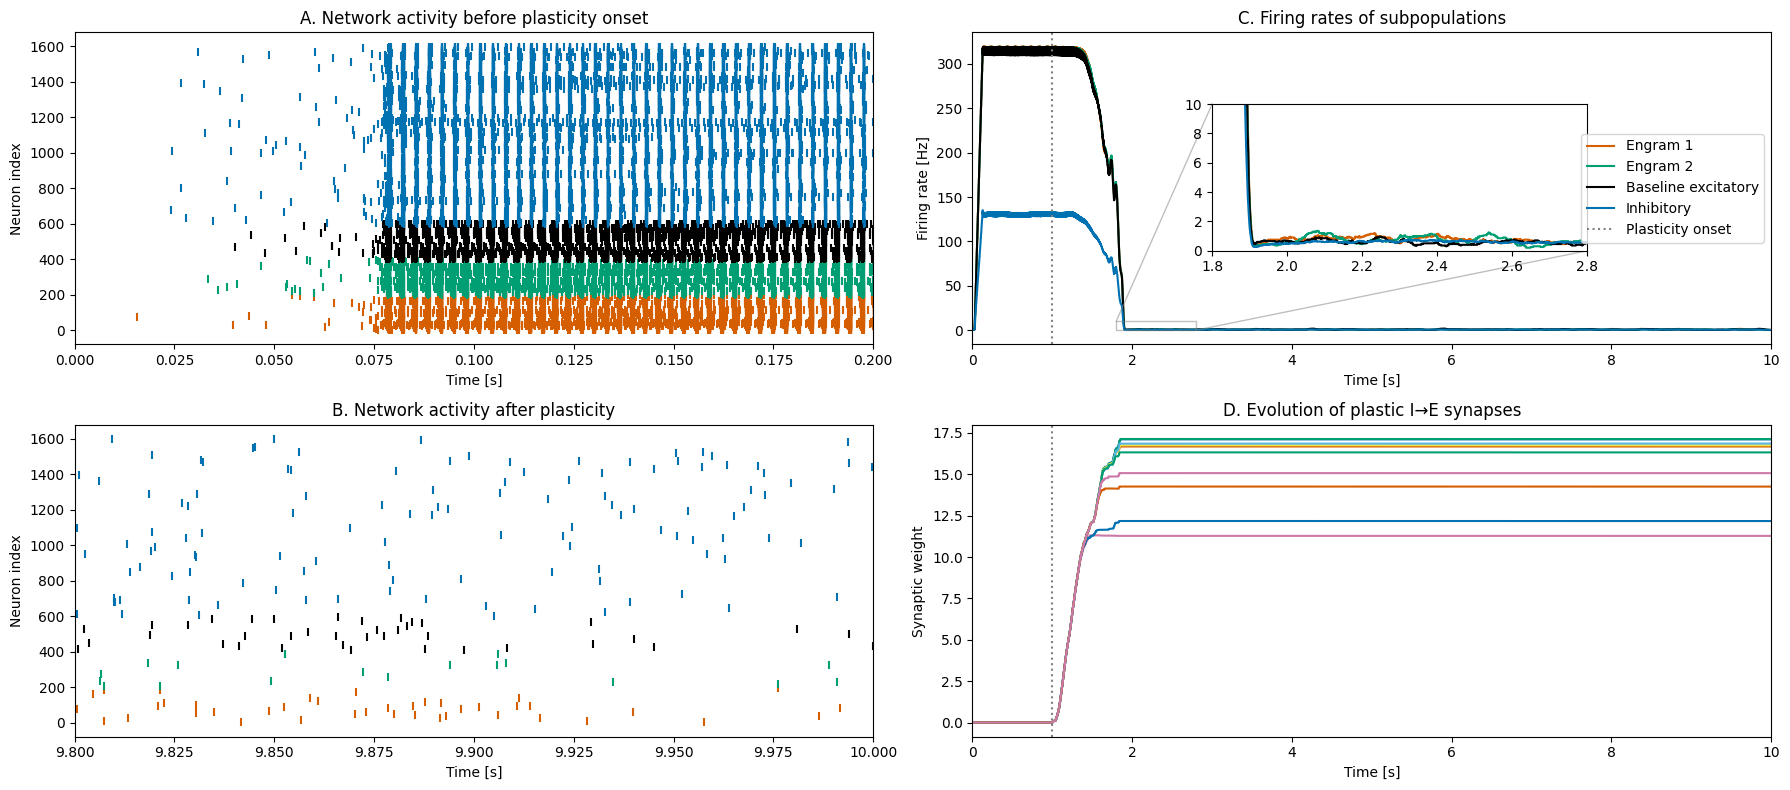

In [14]:
# Visualisation

fig, ax = plt.subplots(2, 2, figsize=(18, 8))

# Extract smoothed rates
def smooth(rate_monitor, window):
    return rate_monitor.smooth_rate(window='flat', width=window * second) / Hz

# Raster plots before/after plasticity
def plot_raster(ax_raster, t_window, title):
    ax_raster.scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
    ax_raster.scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
    ax_raster.scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
    ax_raster.scatter(s_I.t / second, s_I.i +(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color= palette[0], marker='|')
    ax_raster.set_xlim(*t_window)
    ax_raster.set_xlabel('Time [s]')
    ax_raster.set_ylabel('Neuron index')
    ax_raster.set_title(title)

plot_raster(ax[0, 0], (0, 0.2), 'A. Network activity before plasticity onset')
plot_raster(ax[1, 0], (9.8, 10), 'B. Network activity after plasticity')

# Population firing rates
ax[0, 1].plot(r_E1.t / second, smooth(r_E1, 0.1), color=palette[2], label='Engram 1')
ax[0, 1].plot(r_E2.t / second, smooth(r_E2,0.1), color=palette[1], label='Engram 2')
ax[0, 1].plot(r_Ec.t / second, smooth(r_Ec,0.1), color='k', label='Baseline excitatory')
ax[0, 1].plot(r_I.t / second, smooth(r_I,0.1), color=palette[0], label='Inhibitory')
ax[0, 1].set_xlim(0, 10)
ax[0, 1].axvline(1, ls=':', color='grey', label='Plasticity onset')
ax[0, 1].set_xlabel('Time [s]')
ax[0, 1].set_ylabel('Firing rate [Hz]')
ax[0, 1].set_title('C. Firing rates of subpopulations')
ax[0, 1].legend()

# Zoomed inset on rate transitions
x1, x2, y1, y2 = 1.8, 2.8, 0, 10
axins = ax[0, 1].inset_axes([.3, .3, .47, .47], xlim=(x1, x2), ylim=(y1, y2))
axins.plot(r_E1.t / second, smooth(r_E1, 0.1), color=palette[2])
axins.plot(r_E2.t / second, smooth(r_E2, 0.1), color=palette[1])
axins.plot(r_Ec.t / second, smooth(r_Ec, 0.1), color='k')
axins.plot(r_I.t / second, smooth(r_I,0.1), color=palette[0])
ax[0, 1].indicate_inset_zoom(axins)

# Synaptic weight evolution
for i in range(10):
    ax[1, 1].plot(ws.t / second, ws.w[i])
ax[1, 1].axvline(1, ls=':', color='grey', label='Plasticity onset')
ax[1, 1].set_xlim(0, 10)
ax[1, 1].set_xlabel('Time [s]')
ax[1, 1].set_ylabel('Synaptic weight')
ax[1, 1].set_title('D. Evolution of plastic I→E synapses')

fig.tight_layout()
plt.show()

### 5.3 Stabilising inserted memory engrams via inhibitory plasticity

We used inhibitory plasticity to suppress global synchrony and steer the network into an **asynchronous irregular (AI)** regime. In this section, we test the **robustness** of this regime by challenging the network with structured excitatory inputs - **memory engrams**.

A **memory engram** is a subset of neurons with strengthened mutual connectivity, forming an assembly that can be reactivated by partial input. To mimic engram formation, we manually increase the **E→E synaptic weights** within two selected subpopulations.

However, increasing excitatory weights disrupts the EI balance and can lead to pathological reverberations - spontaneous self-activations of the engram that propagate through the network. To prevent this, we will re-enable inhibitory plasticity, allowing the network to self-stabilise by selectively strengthening inhibitory connections to the overactive neurons.

![title](insert_engram_network.png)

In [15]:
# Strengthen connections within engrams
factor = 5
EE.w[engram_1, engram_1] = factor
EE.w[engram_2, engram_2] = factor


# Phase 1: Run network with engram but without plasticity
eta = 0
run(1 * second, report='text')

# Phase 2: Plasticity on
eta = 0.01
run(9 * second, report='text')


Starting simulation at t=10. s for a duration of 1. s
1. s (100%) simulated in 3s
Starting simulation at t=11. s for a duration of 9. s
3.7012 s (41%) simulated in 10s, estimated 14s remaining.
7.2134 s (80%) simulated in 20s, estimated 5s remaining.
9. s (100%) simulated in 25s


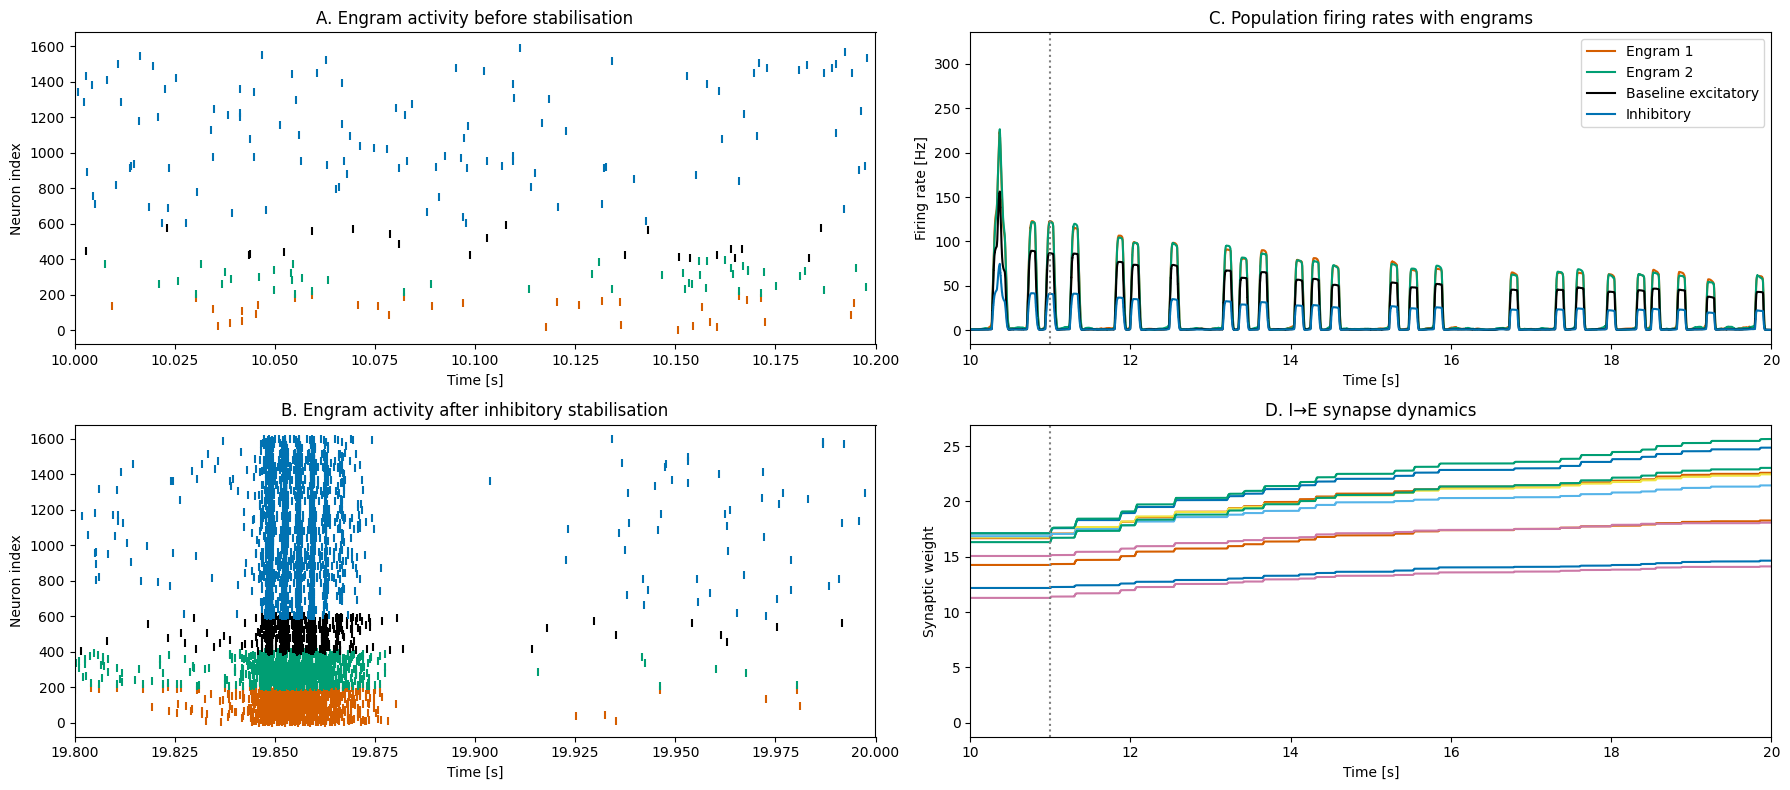

In [16]:
# Visualisation

fig, ax = plt.subplots(2, 2, figsize=(18, 8))

# Raster plots
plot_raster(ax[0, 0], (10, 10.2), 'A. Engram activity before stabilisation')
plot_raster(ax[1, 0], (19.8, 20), 'B. Engram activity after inhibitory stabilisation')

# Firing rates
ax[0, 1].plot(r_E1.t / second, smooth(r_E1, 0.1), color=palette[2], label='Engram 1')
ax[0, 1].plot(r_E2.t / second, smooth(r_E2,0.1), color=palette[1], label='Engram 2')
ax[0, 1].plot(r_Ec.t / second, smooth(r_Ec,0.1), color='k', label='Baseline excitatory')
ax[0, 1].plot(r_I.t / second, smooth(r_I,0.1), color=palette[0], label='Inhibitory')
ax[0, 1].legend()
ax[0, 1].set_xlim(10, 20)
ax[0, 1].axvline(11, ls=':', color='grey', label='Plasticity onset')
ax[0, 1].set_xlabel('Time [s]')
ax[0, 1].set_ylabel('Firing rate [Hz]')
ax[0, 1].set_title('C. Population firing rates with engrams')

# Weight evolution
for i in range(10):
    ax[1, 1].plot(ws.t / second, ws.w[i])
ax[1, 1].axvline(11, ls=':', c='grey', label='Plasticity onset')
ax[1, 1].set_xlim(10, 20)
ax[1, 1].set_xlabel('Time [s]')
ax[1, 1].set_ylabel('Synaptic weight')
ax[1, 1].set_title('D. I→E synapse dynamics')

fig.tight_layout()
plt.show()

In [17]:
# delete monitors for effecient saving and loading of networks
del s_E1,s_E2, s_Ec, s_I
del r_E1,r_E2, r_Ec, r_I
del ws

# save this network state for Bonus section
store(filename='stored_networks/untrained_network')

### 5.4 Long-term stabilisation of the network

After inserting memory engrams into the excitatory–excitatory (E→E) connections, the network displays reverberatory, unstable activity in which engrams spontaneously activate. 

> _Tip: If you want to have a closer look at the spiking dynamics of the spontaneous reactivation, you can set the spike raster on top of the time windows with higher firing rates to have a closer look at the events._

Ultimately, to fully suppress these events and bring the network into a true **asynchronous irregular (AI) state**, we have to allow time for inhibitory plasticity to adapt.

Depending on how much time you have left, you can either:
- Run the network for an additional 3000s yourself by running the cell below (this will take around 90-95 minutes)
- Load a previously saved version of the network by running the cell after it _once_ instead 

In [18]:
### EITHER: Run the network yourself

#run(3000 * second, report='text')

In [19]:
### OR: Restore trained network state

restore(filename='stored_networks/trained_network')

### 5.3 Reactivating "silent" engrams

After inhibitory plasticity stabilises the network and suppresses spontaneous reverberations, the memory engrams are still embedded in the strengthened excitatory weights.

This raises an important question:

_Can these "silent" engrams be selectively reactivated by an external stimulus?_

To test this, we can apply a weak constant input current to a subset of neurons in ```engram_1```, to model partial reactivation of the network. We can then see if the network reactivates the full assembly in response, meaning it supports **pattern completion**, a hallmark of associative memory. 

![title](reactivation_network.png)

In [20]:
# Set up monitors again
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype=int)])
s_I = SpikeMonitor(N_Pop[N_E:])

r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype=int)])
r_I = PopulationRateMonitor(N_Pop[N_E:])

# Subset of engram_1 to stimulate
size_stim = 25
stim_targets = engram_1[:size_stim]
N_Pop.I_e[stim_targets] = 22 * pA

# Additional monitors for stimulated subset
eta = 0  # plasticity remains off
r_stimmed = PopulationRateMonitor(N_Pop[stim_targets])
s_stimmed = SpikeMonitor(N_Pop[stim_targets])

# Run reactivation test
run(1 * second, report='text')

Starting simulation at t=3.02 ks for a duration of 1. s
1. s (100%) simulated in 2s


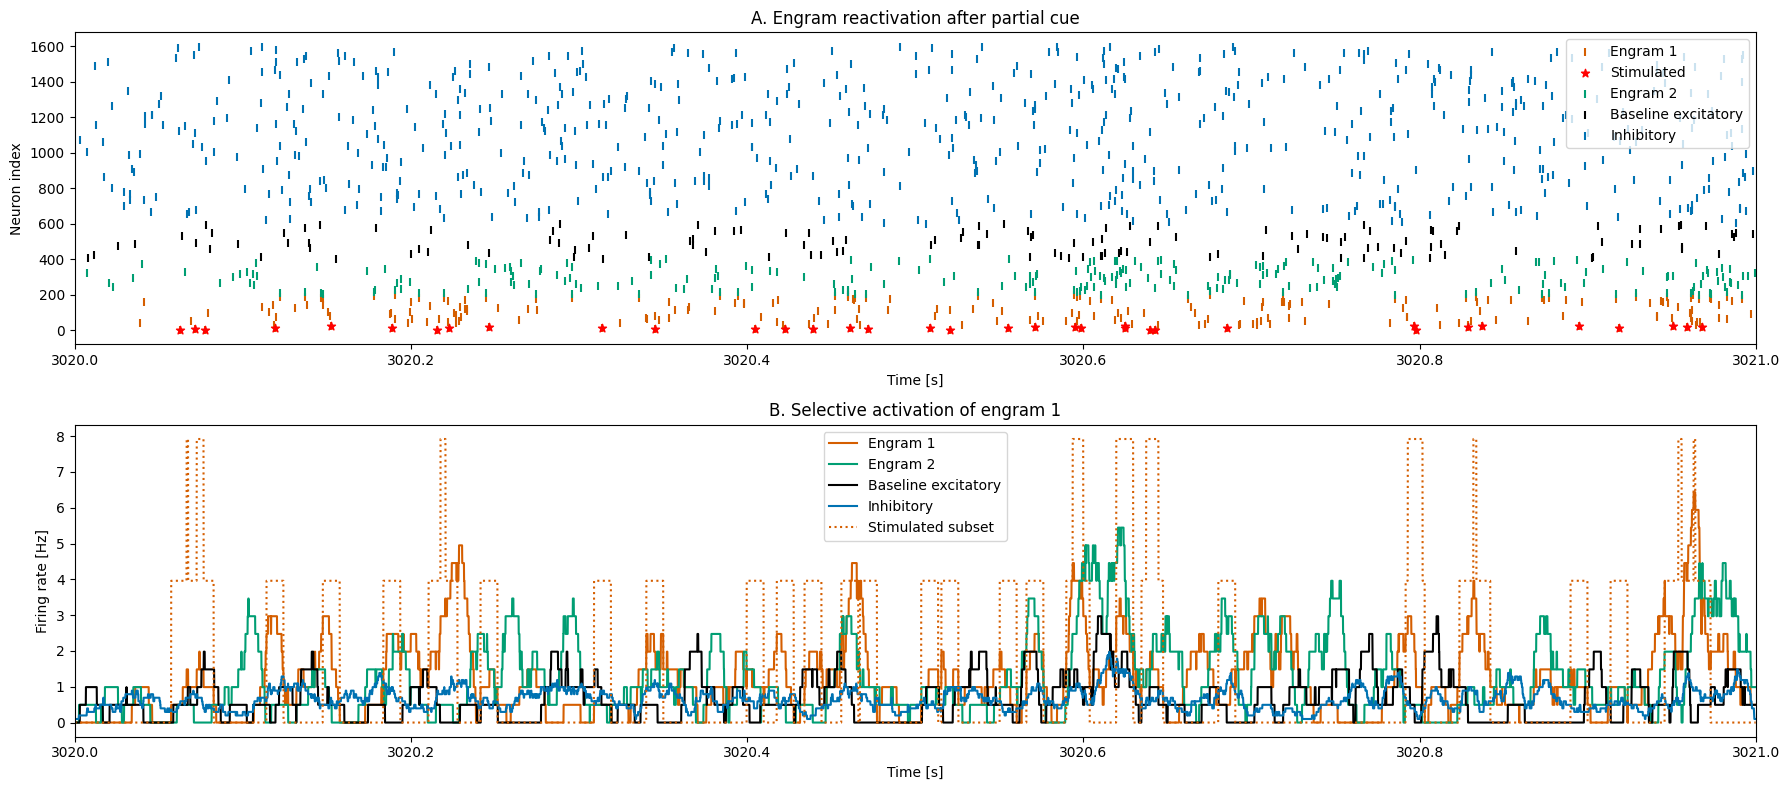

In [21]:
# Plot reactivation
fig, ax = plt.subplots(2, 1, figsize=(18, 8))

# Raster plot with highlighted stimulated neurons
ax[0].scatter(s_E1.t, s_E1.i, color=palette[2], marker='|', label='Engram 1')
ax[0].scatter(s_stimmed.t, s_stimmed.i, color='red', marker='*', label='Stimulated')
ax[0].scatter(s_E2.t, s_E2.i + len(engram_1), color=palette[1], marker='|', label='Engram 2')
ax[0].scatter(s_Ec.t, s_Ec.i + len(engram_1) + len(engram_2), color='k', marker='|', label='Baseline excitatory')
ax[0].scatter(s_I.t, s_I.i + len(engram_1)*2 + len(engram_2), color=palette[0], marker='|', label='Inhibitory')
ax[0].set_xlim(3020, 3021)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Neuron index')
ax[0].set_title('A. Engram reactivation after partial cue')
ax[0].legend(loc='upper right')

# Population rates showing selective activation
ax[1].plot(r_E1.t / second, smooth(r_E1, 0.01), color=palette[2], label='Engram 1')
ax[1].plot(r_E2.t / second, smooth(r_E2,0.01), color=palette[1], label='Engram 2')
ax[1].plot(r_Ec.t / second, smooth(r_Ec,0.01), color='k', label='Baseline excitatory')
ax[1].plot(r_I.t / second, smooth(r_I,0.01), color=palette[0], label='Inhibitory')
ax[1].plot(r_stimmed.t / second, smooth(r_stimmed,0.01), color=palette[2], linestyle=':', label='Stimulated subset')
ax[1].set_xlim(3020, 3021)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Firing rate [Hz]')
ax[1].set_title('B. Selective activation of engram 1')
ax[1].legend()

fig.tight_layout()
plt.show()

*Note*: Pattern completion means that the average rate of Engram 1 and Engram 2 overall increases, while reactivations do not cause avalanches spreading to the baseline excitatory or inhibitory neuron. 


### 5.4 Bonus: Engram reactivation after 500s training

Synaptic learning is fast in the beginning while the network generates reverberations often. Increasingly stronger *I→E* synapses surpress these high activity. Therefore desynchronised activity can be observed early-on. While the activity of the network might suggest that network is stabilised, the *I→E* still learn. Testing the engram reactivation after only **500s** visualises while long simulation times are needed to *fullly* stabilise memory recall despite observing dessynchronised activity. 

In the following we will: 
- reload the network state after engram insertion (t = 20s)
- train the network for 500s (takes 10-15 min) *or* load previously saved version
- partially reactivate Engram 1
- plot the activity

In [22]:
# delete monitors to be able to load previously saved network states
del s_E1,s_E2, s_Ec, s_I
del r_E1,r_E2, r_Ec, r_I
del r_stimmed, s_stimmed

In [23]:
### EITHER: Run the network yourself
# reestablish network state at t=20s
# restore(filename='stored_networks/untrained_network')

#run(500 * second, report='text')

In [24]:
### OR: Restore trained network state

restore(filename='stored_networks/network_after_500s')

In [25]:
# Setup monitors (again for cue)
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
s_I = SpikeMonitor(N_Pop[N_E:])

r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
r_I = PopulationRateMonitor(N_Pop[N_E:])


# Subset of engram_1 to stimulate
size_stim = 25
stim_targets = engram_1[:size_stim]
N_Pop.I_e[stim_targets] = 22 * pA

# Additional monitors for stimulated subset
eta = 0  # plasticity remains off
r_stimmed = PopulationRateMonitor(N_Pop[stim_targets])
s_stimmed = SpikeMonitor(N_Pop[stim_targets])

# Run reactivation test
run(1 * second, report='text')

Starting simulation at t=0.52 ks for a duration of 1. s
1. s (100%) simulated in 3s


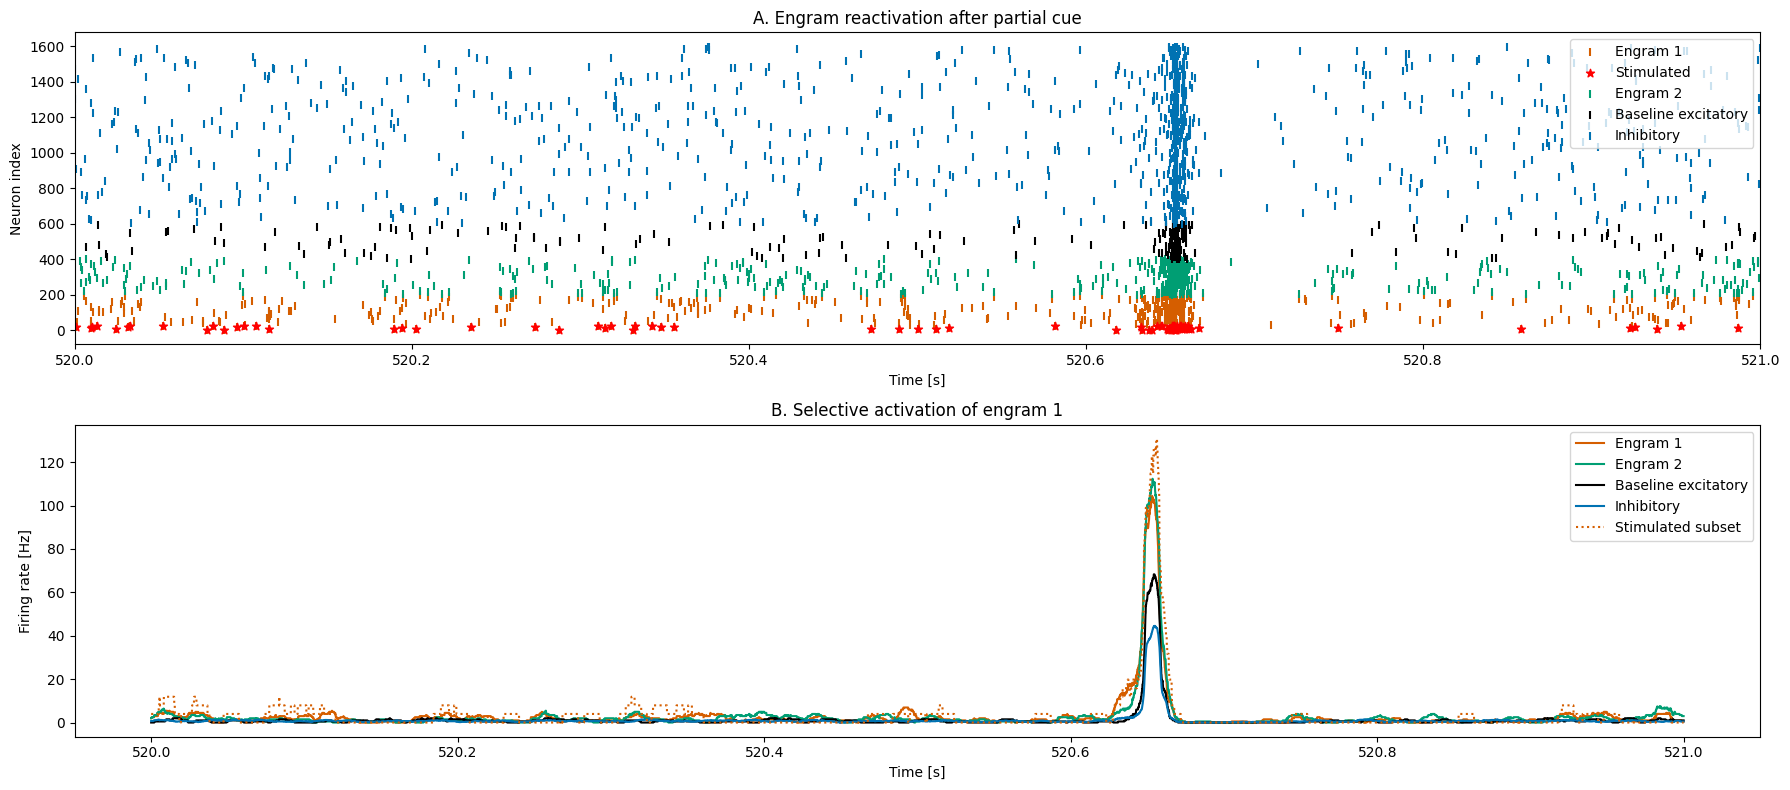

In [26]:
# Plot reactivation
fig, ax = plt.subplots(2, 1, figsize=(18, 8))

# Raster plot with highlighted stimulated neurons
ax[0].scatter(s_E1.t, s_E1.i, color=palette[2], marker='|', label='Engram 1')
ax[0].scatter(s_stimmed.t, s_stimmed.i, color='red', marker='*', label='Stimulated')
ax[0].scatter(s_E2.t, s_E2.i + len(engram_1), color=palette[1], marker='|', label='Engram 2')
ax[0].scatter(s_Ec.t, s_Ec.i + len(engram_1) + len(engram_2), color='k', marker='|', label='Baseline excitatory')
ax[0].scatter(s_I.t, s_I.i + len(engram_1)*2 + len(engram_2), color=palette[0], marker='|', label='Inhibitory')
ax[0].set_xlim(520, 521)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Neuron index')
ax[0].set_title('A. Engram reactivation after partial cue')
ax[0].legend(loc='upper right')

# Population rates showing selective activation
ax[1].plot(r_E1.t / second, smooth(r_E1, 0.01), color=palette[2], label='Engram 1')
ax[1].plot(r_E2.t / second, smooth(r_E2,0.01), color=palette[1], label='Engram 2')
ax[1].plot(r_Ec.t / second, smooth(r_Ec,0.01), color='k', label='Baseline excitatory')
ax[1].plot(r_I.t / second, smooth(r_I,0.01), color=palette[0], label='Inhibitory')
ax[1].plot(r_stimmed.t / second, smooth(r_stimmed,0.01), color=palette[2], linestyle=':', label='Stimulated subset')
ax[0].set_xlim(520, 521)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Firing rate [Hz]')
ax[1].set_title('B. Selective activation of engram 1')
ax[1].legend()

fig.tight_layout()
plt.show()

*Tip:* Feel free to explore how this behaviour changes with training time (changes in code box 23) or changes to the cue (changes in code box 25). You can also explore the effects of changing the cue presented to the network which was trained for 3000s. The needed code snippets can be found below: 

Code cell 19: 
```
### OR: Restore trained network state

restore(filename='stored_networks/trained_network')
```

change to: 
```
### OR: Restore trained network state

del s_E1,s_E2, s_Ec, s_I
del r_E1,r_E2, r_Ec, r_I
del r_stimmed, s_stimmed
restore(filename='stored_networks/trained_network')
```
This will allow you to reload the network state of the *trained_network* without any error messages. 
